In [1]:
import requests
import numpy as np
import math as m
import pandas as pd
import re
import datetime 
import matplotlib.pyplot as plt

In [2]:
def get_playlist_id(channel_id, api_key):
    playlist_url = "https://www.googleapis.com/youtube/v3/channels?"
    playlist_part = "contentDetails"
    playlist_parameters = {"key": api_key,
                           "part": playlist_part,
                           "id": channel_id}

    playlist_query = requests.get(playlist_url, playlist_parameters)
    playlist_results = playlist_query.json()
    playlist_id = playlist_results["items"][0][playlist_part]["relatedPlaylists"]["uploads"]
    return playlist_id

    
def get_video_ids(playlist_id, api_key):
    video_url = "https://www.googleapis.com/youtube/v3/playlistItems?"
    video_part = "snippet"
    max_results = 50  # api supports up to 50
    video_parameters = {"key": api_key,
                        "part": video_part,
                        "playlistId": playlist_id,
                        "maxResults": max_results,
                        "pageToken": ""}
    video_query = requests.get(video_url, video_parameters)
    video_results = video_query.json()
    video_data = []
    for i in range(len(video_results["items"])):
        video_data.append(video_results["items"][i]["snippet"]["resourceId"]["videoId"])
    while "nextPageToken" in video_results:
        video_parameters["pageToken"] = video_results["nextPageToken"]
        video_query = requests.get(video_url, video_parameters)
        video_results = video_query.json()
        for i in range(len(video_results["items"])):
            video_data.append(video_results["items"][i]["snippet"]["resourceId"]["videoId"])            
    return video_data

    
def get_video_info(video_ids, api_key):    
    video_url = "https://www.googleapis.com/youtube/v3/videos?"
    video_part = "snippet, contentDetails, statistics"
    snippet_columns = ["title", "description","categoryId", "publishedAt"] #, "defaultAudioLanguage"
    statistics_columns = ["viewCount", "likeCount", "dislikeCount", "favoriteCount","commentCount"]
    output = []
    i = 0
    while(((i*50) + 50) < len(video_ids)):
        id_list = ", ".join(video_ids[i*50:50+(i*50)])
        video_parameters = {"key": api_key,
                            "id": id_list,
                            "part": video_part}
    
        video_query = requests.get(video_url, video_parameters)
        video_results = video_query.json()
        for j in range(50):
            row = [video_ids[(i*50)+j]]
            row.extend([video_results["items"][j]["snippet"][column] for column in snippet_columns])
            row[-1] = datetime.datetime.strptime(row[-1], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%m/%d/%Y %H:%M:%S')
            row.append(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S'))
            row.append(get_duration_in_seconds(video_results["items"][j]["contentDetails"]["duration"]))  
            row.extend([video_results["items"][j]["statistics"][column] for column in statistics_columns])
            output.append(row)
            j = j + 1
        i = i + 1
        
    id_list = ", ".join(video_ids[i*50:len(video_ids)])
    video_parameters = {"key": api_key,
                        "id": id_list,
                        "part": video_part}

    video_query = requests.get(video_url, video_parameters)
    video_results = video_query.json()
    for j in range(len(video_ids) - i*50):
        row = [video_ids[(i*50)+j]]
        row.extend([video_results["items"][j]["snippet"][column] for column in snippet_columns])
        row[-1] = datetime.datetime.strptime(row[-1], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%m/%d/%Y %H:%M:%S')
        row.append(datetime.datetime.now().strftime('%m/%d/%Y %H:%M:%S'))
        row.append(get_duration_in_seconds(video_results["items"][j]["contentDetails"]["duration"]))  
        row.extend([video_results["items"][j]["statistics"][column] for column in statistics_columns])
        output.append(row)
        j = j + 1
    i = i + 1
    return output


def get_duration_in_seconds(duration):    
    days = re.findall(r'[0-9]+D', duration)
    hours = re.findall(r'[0-9]+H', duration)
    minutes = re.findall(r'[0-9]+M', duration)
    seconds = re.findall(r'[0-9]+S', duration)
    if len(days) == 0:
        days = "00"
    else:
        days = days[0][:-1].rjust(2, '0') 
    if len(hours) == 0:
        hours = "00"
    else:
        hours = hours[0][:-1].rjust(2, '0')
    if len(minutes) == 0:
        minutes = "00"
    else:
        minutes = minutes[0][:-1].rjust(2, '0') 
    if len(seconds) == 0:
        seconds = "00"
    else:
        seconds = seconds[0][:-1].rjust(2, '0') 
    hours = int(hours) + int(days)*24
    minutes = int(minutes) + int(hours)*60
    seconds = int(seconds) + int(minutes)*60
    return seconds

In [102]:


arxiv = "UCNIkB2IeJ-6AmZv7bQ1oBYg" #arXiv
dunkey = "UCsvn_Po0SmunchJYOWpOxMg" #dunkey
mphan = "UCuYx81nzzz4OFQrhbKDzTng" #michelle phan

columns = ["id", "title", "description", "categoryId", "publishedAt", "lastAvailable", "duration", "viewCount", "likeCount", "dislikeCount", "favoriteCount","commentCount"]

uploads = get_playlist_id(mphan, api_key)
video_ids = get_video_ids(uploads, api_key)
video_dataframe = pd.DataFrame(get_video_info(video_ids, api_key), columns=columns)
video_dataframe["publishedAt"] = pd.to_datetime(video_dataframe["publishedAt"])
video_dataframe = video_dataframe.sort_values(by=["publishedAt"], ascending=False)
video_dataframe.head()

,id,title,description,categoryId,publishedAt,lastAvailable,duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
0,UuGpm01SPcA,Why I Left,I wanted to share my side of the story to my v...,26,2017-06-01 19:45:34,11/08/2018 23:13:23,672,12379461,604780,24245,0,49054
1,1-31plM1sJ4,Mastering the Art of Hair Removal,Hi beauties! Sorry I've been away from this ch...,26,2016-07-25 09:29:06,11/08/2018 23:13:23,297,2288779,51814,1376,0,3265
2,6OQnYhYyeoE,Mastering the Art of Sunless Tanning,MY WEBCOMIC HELIOS : FEMINA is free to read h...,26,2016-07-01 13:00:00,11/08/2018 23:13:23,330,594873,16623,526,0,1284
3,MXm7obi1yHM,Final Dynasty : Aesthetic Inspiration,You can binge read my story book HELIOS : FEMI...,26,2016-06-18 15:45:49,11/08/2018 23:13:23,121,1843146,57415,2158,0,4207
4,1N3QQXxZ1SQ,Mastering the Art of Cushion Compacts,MY WEBCOMIC HELIOS : FEMINA is free to read h...,26,2016-06-13 20:21:12,11/08/2018 23:13:23,305,1488645,43560,1029,0,1956


In [103]:
def search_video_ids(channel_id, api_key):
    search_url = "https://www.googleapis.com/youtube/v3/search?"
    max_results = 50 #api supports up to 50
    search_parameters = {"key": api_key,
                         "type": "video",
                         "part": "id",
                         "maxResults": max_results,
                         "order": "date",
                         "channelId": channel_id}
    
    search_query = requests.get(search_url, search_parameters)
    search_results = search_query.json()    
    video_list = []
    for i in range(len(search_results["items"])):
        video_list.append(search_results["items"][i]["id"]["videoId"])

    while "nextPageToken" in search_results:
        search_parameters["pageToken"] = search_results["nextPageToken"]
        search_query = requests.get(search_url, search_parameters)
        search_results = search_query.json() 
        for i in range(len(search_results["items"])):
            video_list.append(search_results["items"][i]["id"]["videoId"])   
    return video_list

test = search_video_ids(mphan, api_key)
set(video_ids) == set(test).union(set(video_ids))
#searching by channel id does not appear to return any extra videos compared to search by uploads playlist

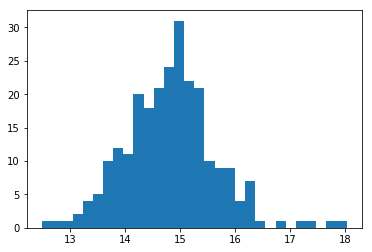

In [105]:
view_counts = [m.log(int(x)) for x in video_dataframe["viewCount"]]
plt.hist(view_counts, 30)
plt.show();

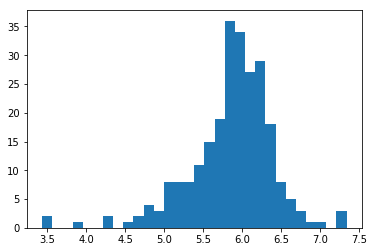

In [106]:
durations = np.log(video_dataframe["duration"])
plt.hist(durations, 30)
plt.show();

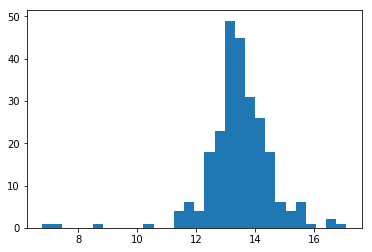

In [107]:
uploads = [datetime.datetime.strptime(str(time), "%Y-%m-%d %H:%M:%S") for time in video_dataframe["publishedAt"]]
uploads = [m.log(-delta.total_seconds()) for delta in np.diff(uploads)]
plt.hist(uploads, 30)
plt.show();

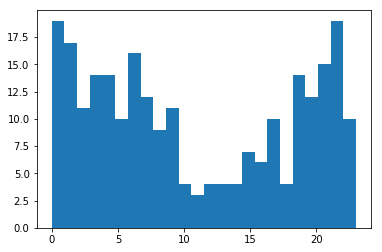

In [108]:
hours = [time.hour for time in video_dataframe["publishedAt"]]
plt.hist(hours, 24)
plt.show();

In [109]:
for i in range(24):
    print(str(i)+" o'clock:", hours.count(i))

0 o'clock: 19
1 o'clock: 17
2 o'clock: 11
3 o'clock: 14
4 o'clock: 14
5 o'clock: 10
6 o'clock: 16
7 o'clock: 12
8 o'clock: 9
9 o'clock: 11
10 o'clock: 4
11 o'clock: 3
12 o'clock: 4
13 o'clock: 4
14 o'clock: 4
15 o'clock: 7
16 o'clock: 6
17 o'clock: 10
18 o'clock: 4
19 o'clock: 14
20 o'clock: 12
21 o'clock: 15
22 o'clock: 19
23 o'clock: 10
